### Initializing Dask Client for Parallel Processing

In this step, we initialize a **Dask distributed client** to enable **parallel processing**, which significantly speeds up data handling—especially when working with large datasets.

#### **How it Works**:
- We check if a `client` already exists. If not, a new Dask client is started with:
  - **16 workers**
  - **2 threads per worker**
  - **30 GB of memory limit**
- If a client is already running, it reuses the existing session.
- We also print the current versions of **Dask** and **Pandas** to confirm the environment.

This setup allows Dask to parallelize computation across multiple cores and manage memory more efficiently, improving performance for data-intensive tasks.


In [11]:
import dask
from dask.distributed import Client

try:
    client
except NameError:
    print("No dask client defined, starting client")
    client = Client(n_workers=16, threads_per_worker=2, memory_limit='30GB')  # start distributed scheduler locally.
else:
    print("Dask client already defined.")

print(f'Dask version: {dask.__version__}')
print(f'Pandas version: {pd.__version__}')

# Display the client details to confirm it's running
client

No dask client defined, starting client
Dask version: 2024.5.0
Pandas version: 2.2.2


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 447.03 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55178,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 447.03 GiB
Comm: tcp://127.0.0.1:55242,Total threads: 2
Dashboard: http://127.0.0.1:55243/status,Memory: 27.94 GiB
Nanny: tcp://127.0.0.1:55181,


### Reading and Processing Batch Data Files

In this section, we load and preprocess jerky batch data files using **Dask** for efficient handling of large datasets.

#### **Key Steps**:
1. **Directory Scanning**: All `.csv` files in the specified `data/` directory are listed for processing.
2. **Standardization**: We define a set of expected columns and corresponding data types to ensure consistency across all files.
3. **Data Loading**:
   - Files are read into a Dask DataFrame with no header assumed.
   - Columns are renamed to match the predefined schema.
   - Each column is cast to its expected data type.
4. **Pressure Correction**: Pressure values are converted to kilopascals (kPa) by dividing by 1000.
5. **Computation**: The Dask DataFrame is computed into a regular Pandas DataFrame for further analysis.

#### **Data Validation**:
- **Log Events**: Rows containing `"Log event started"` or `"Log event stopped"` are extracted.
- **Incorrect Entries**: Entries are flagged as incorrect if:
  - They contain `"Log event started"` in the `Pressure_sym` column.
  - They are missing the `Weight_1` value.

#### **Summary Output**:
We print the total number of entries along with counts of start/stop log events and incorrectly formatted rows.

Finally, we export all categorized DataFrames to separate CSV files for further inspection.


In [2]:
import dask.dataframe as dd
import pandas as pd
import os

# Directory containing CSV files
directory = r'data'

# Define standard columns and data types
standard_columns = [
    'MAC', 'Unix_time_Stamp', 'Date', 'Temp', 'Temp_sym', 
    'Humidity', 'Humidity_sym', 'Pressure', 'Pressure_sym', 
    'IDs_1', 'ID_1', 'Weight_1', 'Wt_sym_1', 
    'IDs_2', 'ID_2', 'Weight_2', 'Wt_sym_2', 
    'IDs_3', 'ID_3', 'Weight_3', 'Wt_sym_3', 
    'IDs_4', 'ID_4', 'Weight_4', 'Wt_sym_4', 
    'IDs_5', 'ID_5', 'Weight_5', 'Wt_sym_5'
]

# Define dtypes
dtypes = {
    'MAC': 'string',
    'Unix_time_Stamp': 'uint64',
    'Temp': 'float64',
    'Temp_sym': 'string',
    'Humidity': 'float64',
    'Humidity_sym': 'string',
    'Pressure': 'int64',
    'Pressure_sym': 'string',
    'IDs_1': 'string',
    'ID_1': 'int64',
    'Weight_1': 'int64',
    'Wt_sym_1': 'string', 
    'IDs_2': 'string',
    'ID_2': 'int64',
    'Weight_2': 'int64',
    'Wt_sym_2': 'string', 
    'IDs_3': 'string',
    'ID_3': 'int64',
    'Weight_3': 'int64',
    'Wt_sym_3': 'string', 
    'IDs_4': 'string',
    'ID_4': 'int64',
    'Weight_4': 'int64',
    'Wt_sym_4': 'string', 
    'IDs_5': 'string',
    'ID_5': 'int64',
    'Weight_5': 'int64',
    'Wt_sym_5': 'string'
}

# List all CSV files in the directory
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]

# Read all CSV files with Dask
ddf = dd.read_csv(csv_files, header=None, assume_missing=True)

# Rename columns and reorder
ddf = ddf.rename(columns=dict(enumerate(standard_columns)))
ddf = ddf[[col for col in standard_columns if col in ddf.columns]]

# Convert data types
for col, dtype in dtypes.items():
    if dtype == 'int64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('Int64')
    elif dtype == 'float64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('float64')
    else:
        ddf[col] = ddf[col].astype(dtype)

# Convert Pressure to float64 and divide by 1000
ddf['Pressure'] = (ddf['Pressure'] / 1000).astype('float64')

# Compute the DataFrame (trigger computation)
combined_df = ddf.compute()

# Display the first few rows
#display(combined_df.head())

# Identify log events or incorrect entries
log_event_stopped_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event stopped', na=False)]

log_event_start_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False)]

# Assume that any row without a standard number of columns or containing 'Log event started' is incorrect
incorrect_entries_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False) | (combined_df['Weight_1'].isna())]

print("Total Entries:", len(combined_df))
print("Log Event Starts:", len(log_event_start_df))
print("Log Event Stopped:", len(log_event_stopped_df))
print("Incorrect Entries:", len(incorrect_entries_df))

# Save these DataFrames to separate CSV files for further analysis
combined_df.to_csv('total_entries.csv', index=False)
log_event_start_df.to_csv('log_event_starts.csv', index=False)
log_event_stopped_df.to_csv('log_event_stopped.csv', index=False)
incorrect_entries_df.to_csv('incorrect_entries.csv', index=False)

Dask version: 2024.5.0
Pandas version: 2.2.2
Total Entries: 39694
Log Event Starts: 23
Log Event Stopped: 23
Incorrect Entries: 58


### Previewing the Combined DataFrame

In this step, we inspect the combined and processed dataset:

- **Shape**: Displays the total number of rows and columns in the DataFrame.
- **Head**: Shows the first few rows to review initial entries and confirm successful parsing.
- **Tail**: Displays the last few rows to check for any trailing or malformed data at the end of the file.


In [12]:
# Print the first few rows of the combined DataFrame
print(combined_df.shape)
display(combined_df.head())
display(combined_df.tail())

(39694, 29)


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
0,7C:DF:A1:E0:91:AC,1674573949,2023-01-24 15:25:49,22.2,C,30.0,%,96.121,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,7C:DF:A1:E0:91:AC,1674573949,2023-01-24 15:25:49,22.2,C,30.0,%,96.121,hPa,id,1,824,g,id,2,171,g,id,3,580,g,id,4,517,g,id,5,399,g
2,7C:DF:A1:E0:91:AC,1674574200,2023-01-24 15:30:00,22.1,C,30.7,%,96.144,hPa,id,1,820,g,id,2,170,g,id,3,579,g,id,4,516,g,id,5,399,g
3,7C:DF:A1:E0:91:AC,1674576000,2023-01-24 16:00:00,22.1,C,29.1,%,96.272,hPa,id,1,817,g,id,2,169,g,id,3,576,g,id,4,512,g,id,5,398,g
4,7C:DF:A1:E0:91:AC,1674577800,2023-01-24 16:30:00,21.1,C,29.6,%,96.379,hPa,id,1,814,g,id,2,169,g,id,3,573,g,id,4,509,g,id,5,397,g


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
43,7C:DF:A1:E0:91:AC,1745962200,2025-04-29 21:30:00,20.0,C,26.1,%,98.663,hPa,id,1,1,g,id,2,-4,g,id,3,-1,g,id,4,7,g,id,5,-1,g
44,7C:DF:A1:E0:91:AC,1745964000,2025-04-29 22:00:00,19.9,C,26.4,%,98.646,hPa,id,1,1,g,id,2,-5,g,id,3,-1,g,id,4,7,g,id,5,-1,g
45,7C:DF:A1:E0:91:AC,1745965800,2025-04-29 22:30:00,19.9,C,26.4,%,98.609,hPa,id,1,1,g,id,2,-5,g,id,3,-1,g,id,4,7,g,id,5,-1,g
46,7C:DF:A1:E0:91:AC,1745967600,2025-04-29 23:00:00,19.9,C,26.4,%,98.624,hPa,id,1,1,g,id,2,-4,g,id,3,-1,g,id,4,7,g,id,5,-1,g
47,7C:DF:A1:E0:91:AC,1745969400,2025-04-29 23:30:00,19.9,C,26.2,%,98.615,hPa,id,1,1,g,id,2,-4,g,id,3,-1,g,id,4,7,g,id,5,-1,g


### Visualizing All Recorded Data

In this step, we plot the complete dataset to visualize the recorded actions:

1. **Weights over Time**: Multiple weight readings (`Weight_1`, `Weight_2`, `Weight_3`, `Weight_4`, `Weight_5`) are plotted on the left y-axis with different colors for each weight.
2. **Log Events**: Vertical lines indicate when a log event was started (green) or stopped (red) based on their respective dates.
3. **Temperature and Humidity**: Plotted on the right y-axis, showing temperature and humidity trends over time.
4. **Legends**: Legends for both axes are combined, with the temperature and humidity data displayed on the right and the weight data on the left.
5. **Layout**: The layout is adjusted to ensure the legend fits outside the plot area.

This visualization helps analyze how the weights change over time in relation to environmental conditions and log events.


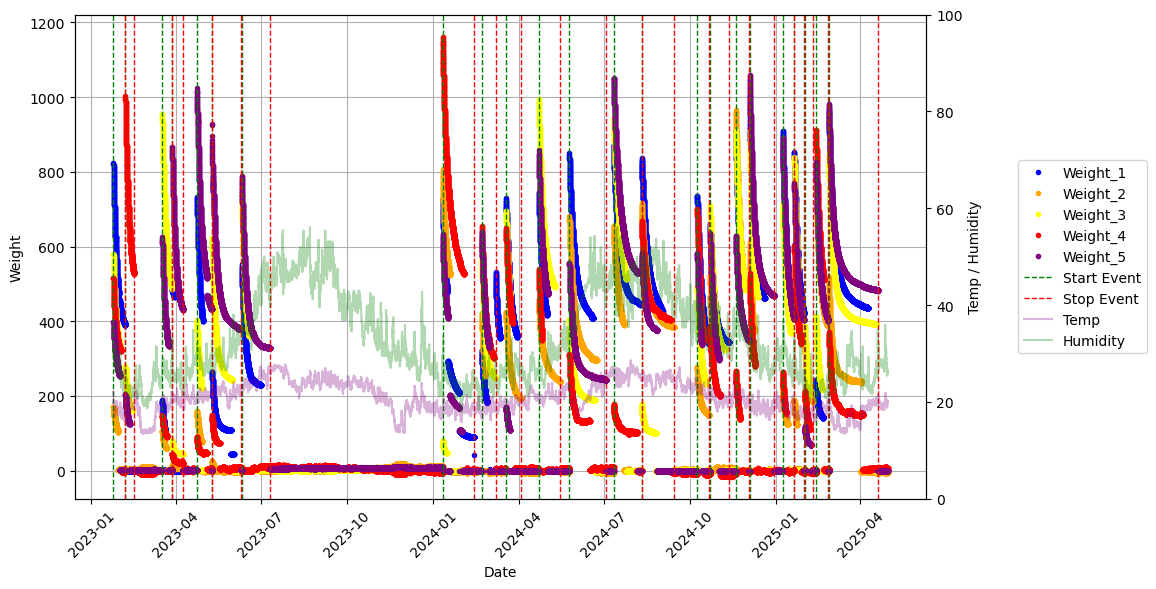

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
filtered_df = combined_df.copy()  # Use .copy() to avoid working with a view
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Use .loc[] to modify the DataFrame explicitly
log_event_start_df.loc[:, 'Date'] = pd.to_datetime(log_event_start_df['Date'])
log_event_stopped_df.loc[:, 'Date'] = pd.to_datetime(log_event_stopped_df['Date'])

fig, ax1 = plt.subplots(figsize=(14, 6))  # wider figure

# Plot weights on primary y-axis (left)
ax1.plot(filtered_df['Date'], filtered_df['Weight_1'], 'o', color='b', label='Weight_1', markersize=3)
ax1.plot(filtered_df['Date'], filtered_df['Weight_2'], 'o', color='orange', label='Weight_2', markersize=3)
ax1.plot(filtered_df['Date'], filtered_df['Weight_3'], 'o', color='yellow', label='Weight_3', markersize=3)
ax1.plot(filtered_df['Date'], filtered_df['Weight_4'], 'o', color='red', label='Weight_4', markersize=3)
ax1.plot(filtered_df['Date'], filtered_df['Weight_5'], 'o', color='purple', label='Weight_5', markersize=3)

for log_date in log_event_start_df['Date']:
    ax1.axvline(x=log_date, color='green', linestyle='--', linewidth=1, label='Start Event')

for log_date in log_event_stopped_df['Date']:
    ax1.axvline(x=log_date, color='red', linestyle='--', linewidth=1, label='Stop Event')

ax1.set_xlabel('Date')
ax1.set_ylabel('Weight')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis (right) for temperature and humidity
ax2 = ax1.twinx()
ax2.plot(filtered_df['Date'], filtered_df['Temp'], '-', color='purple', label='Temp', alpha=0.3)
ax2.plot(filtered_df['Date'], filtered_df['Humidity'], '-', color='green', label='Humidity', alpha=0.3)
ax2.set_ylabel('Temp / Humidity')
ax2.set_ylim(0, 100)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels_1 + labels_2, lines_1 + lines_2))
ax1.legend(by_label.values(), by_label.keys(), loc='best')

# Combine and place legend outside the plot area
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels_1 + labels_2, lines_1 + lines_2))
ax1.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.1, 0.5))

fig.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on right
plt.show()

### Data Processing and Plotting

This cell processes jerky piece weight data, modifies specific rows for missing or abrupt changes, and splits the dataset based on log events. For each event, the following steps occur:

1. **Data Filtering**: The DataFrame is filtered to only include rows with weights greater than 50.
2. **Handling Abrupt Changes**: Specific rows and ranges are adjusted to handle sudden data jumps. The fix was hardcoded in as it only affected the first few batches, the sudden data disjoints have been resolved in all future batches.
3. **Weight Data Export**: Weight data for each jerky piece is exported as CSV files.
4. **Plotting**: A plot is generated for each event, showing the weight trends along with temperature and humidity, and marking the start and end of each log event with vertical lines.


Start: 2023-01-24 15:30:00
End: 2023-02-06 09:00:00


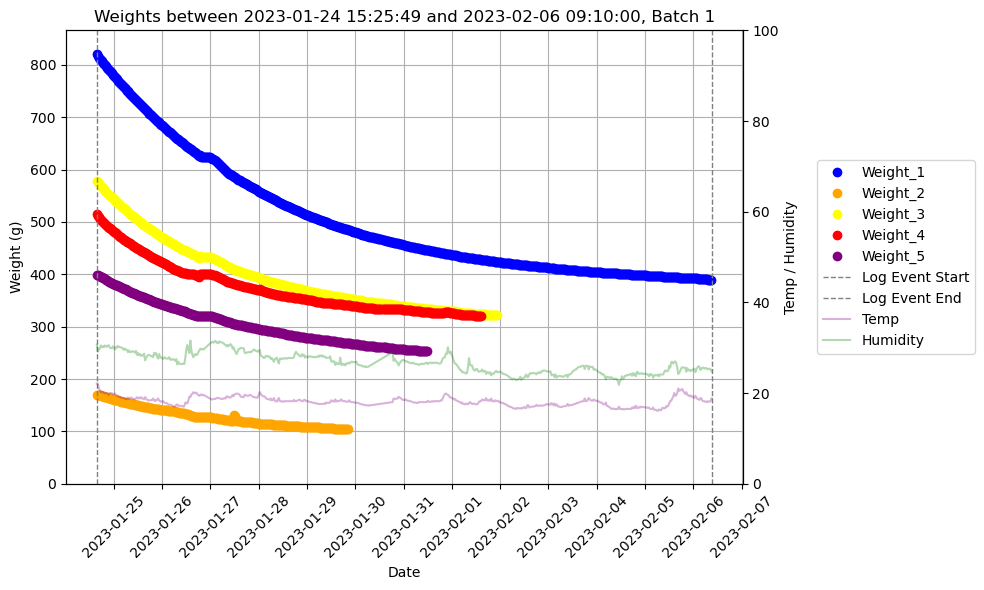

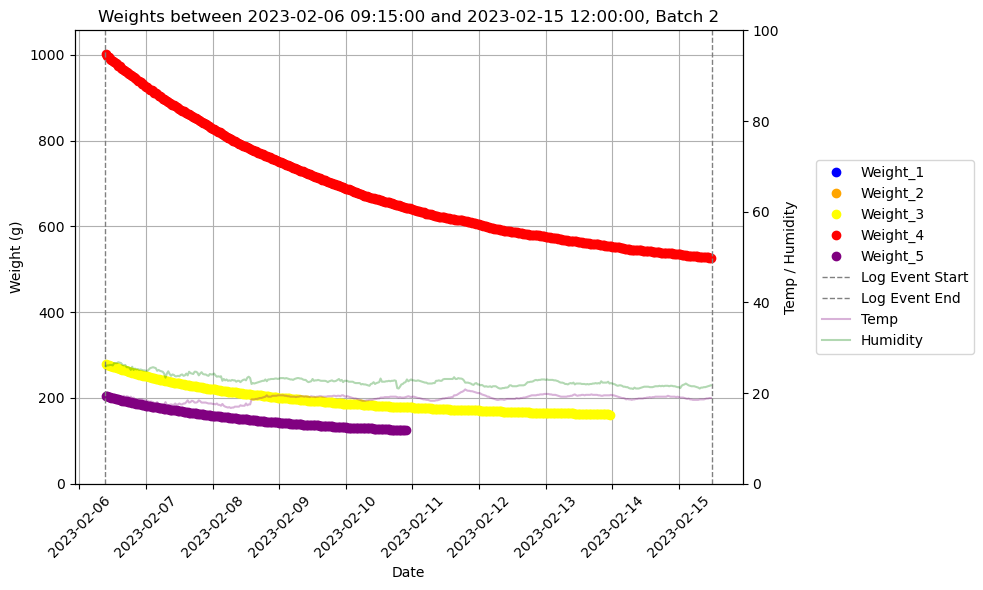

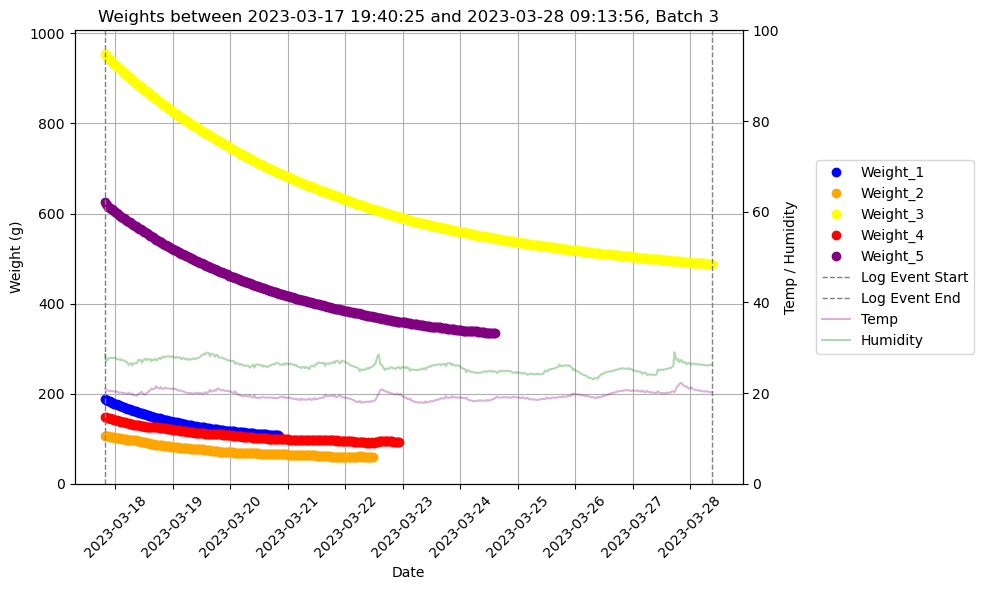

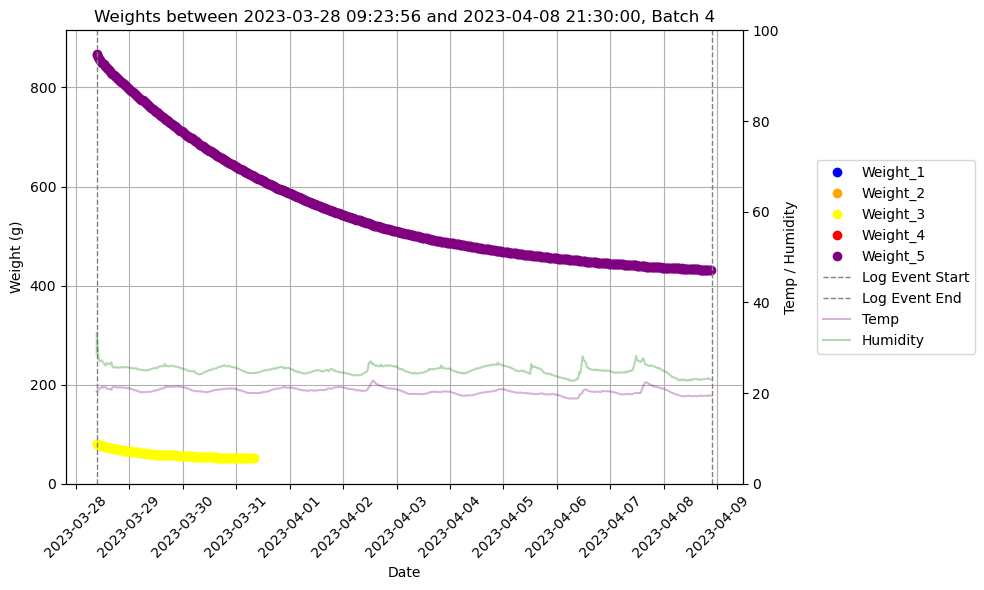

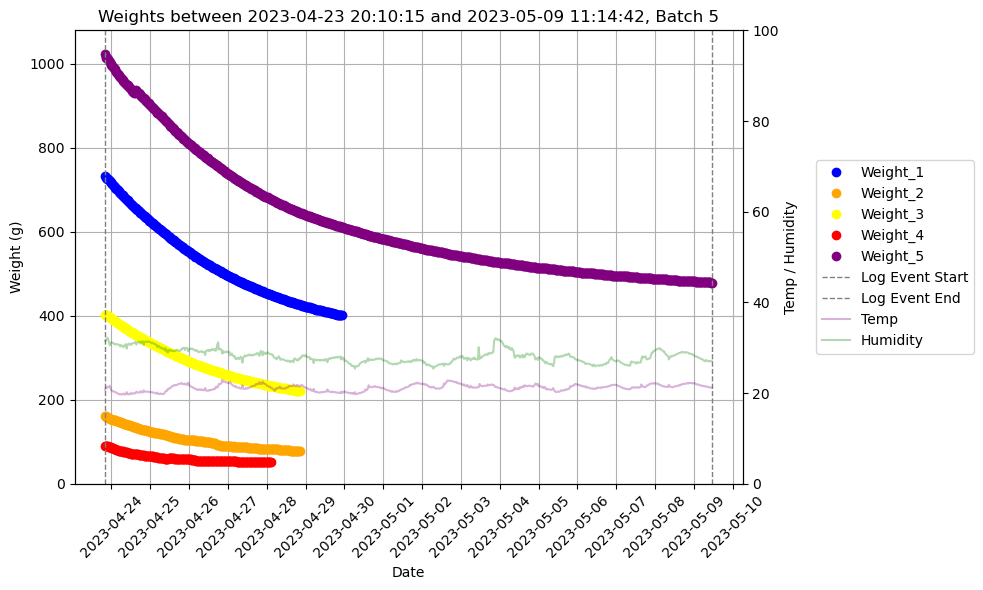

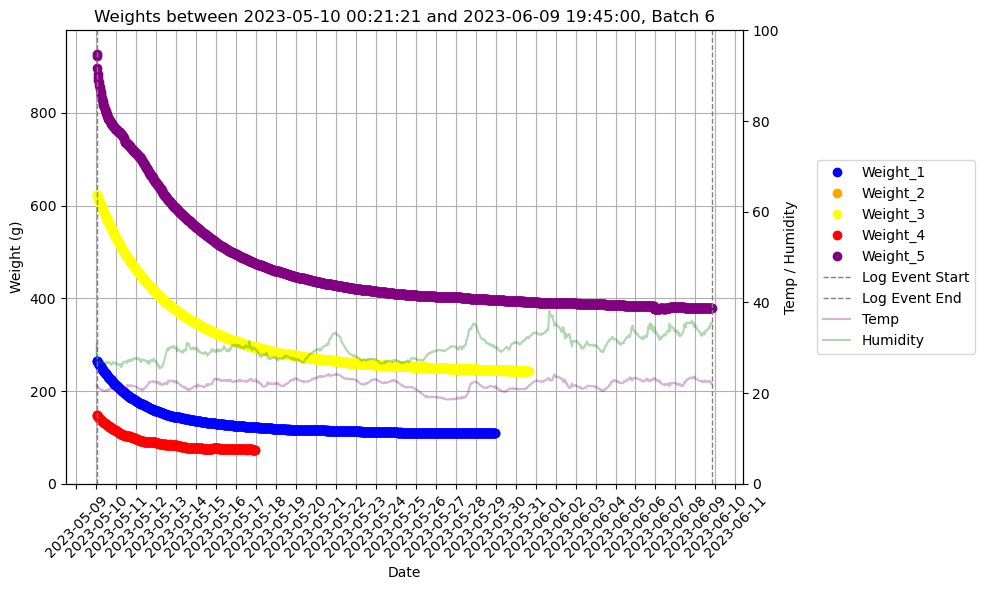

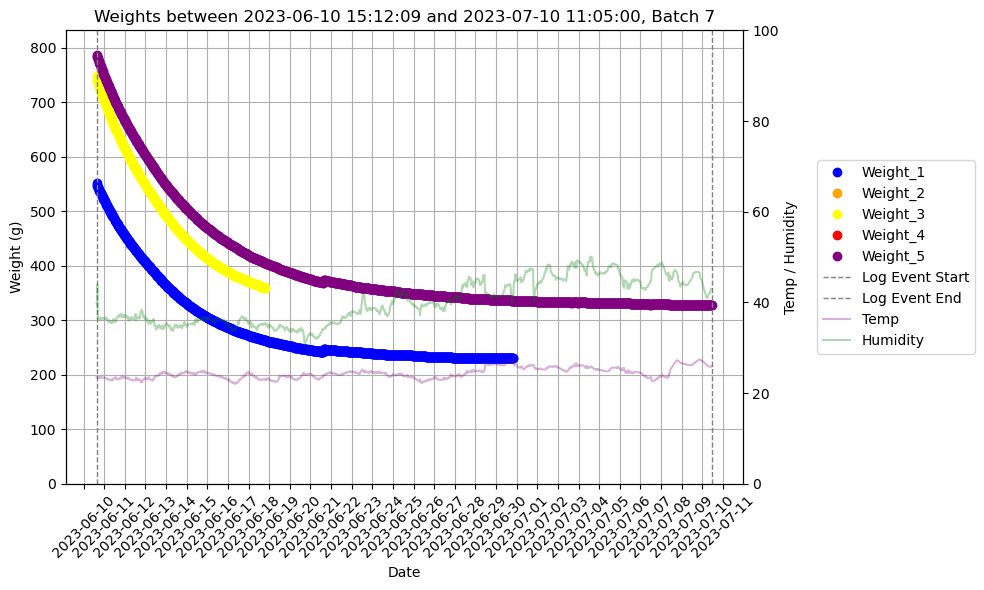

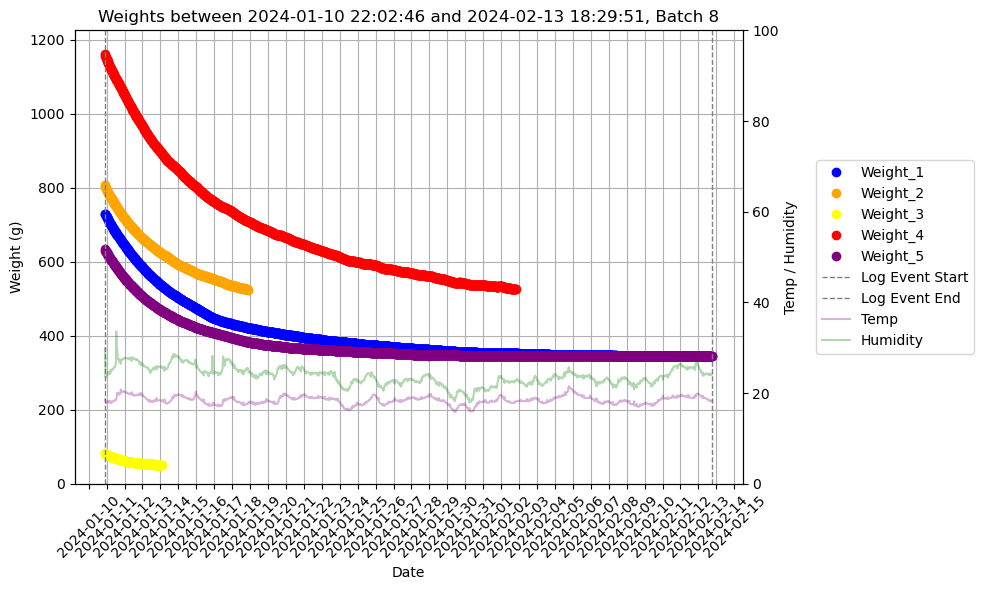

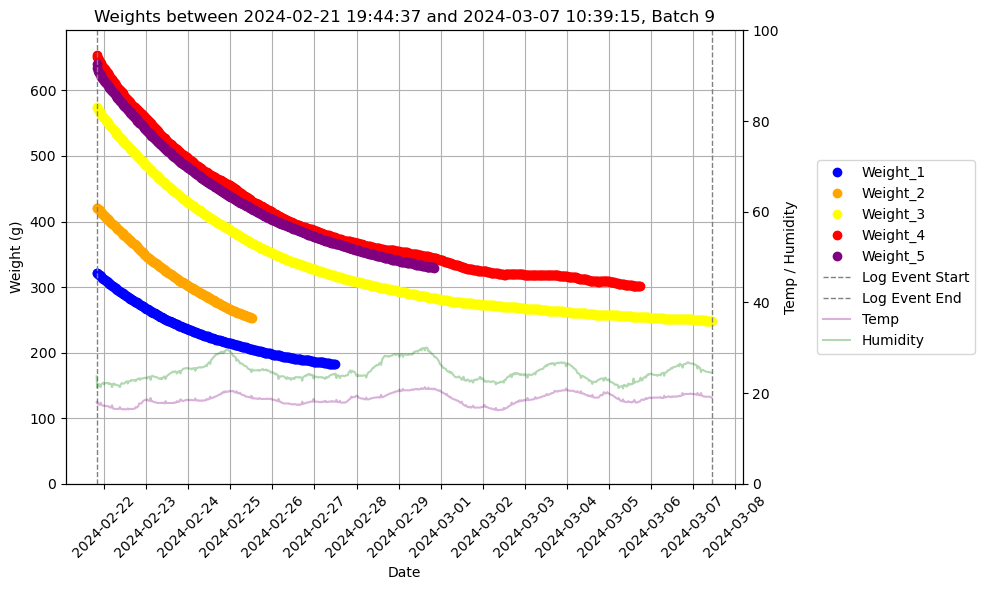

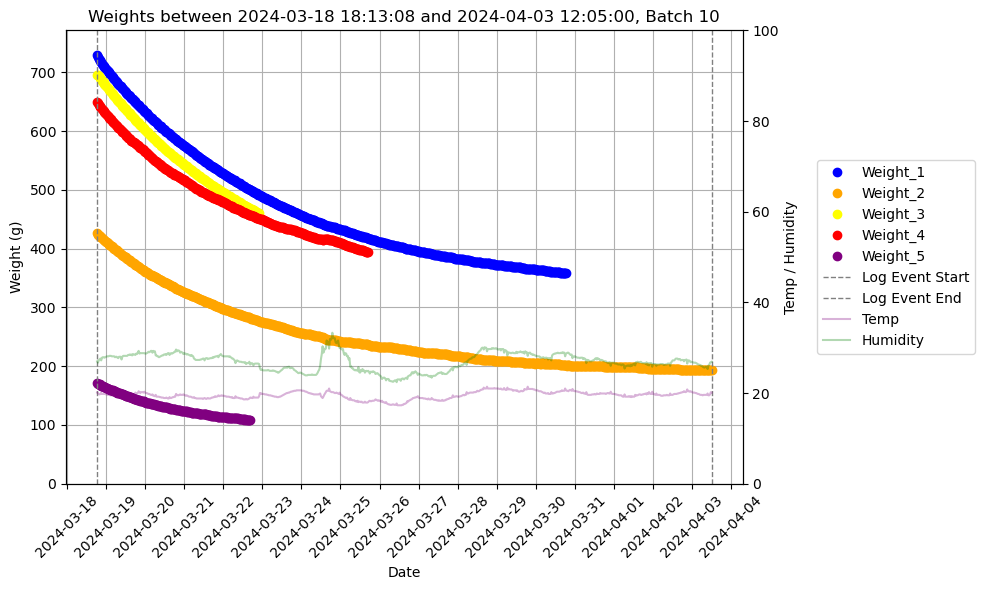

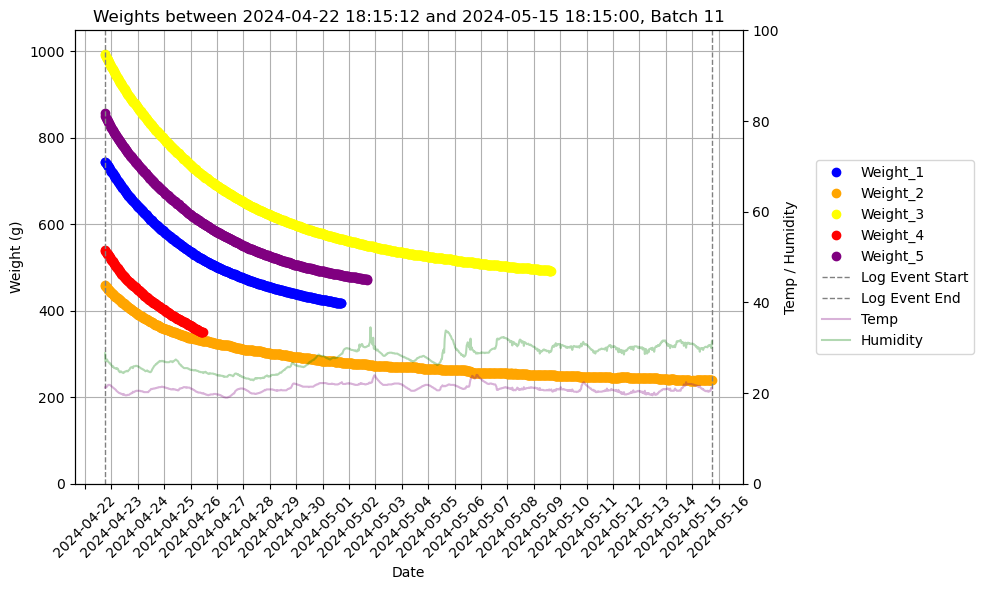

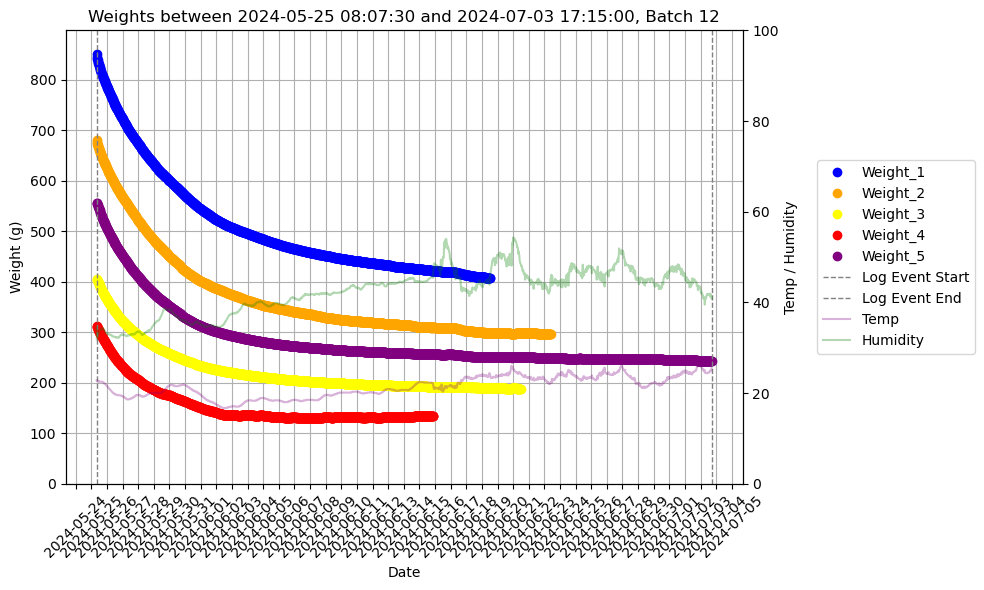

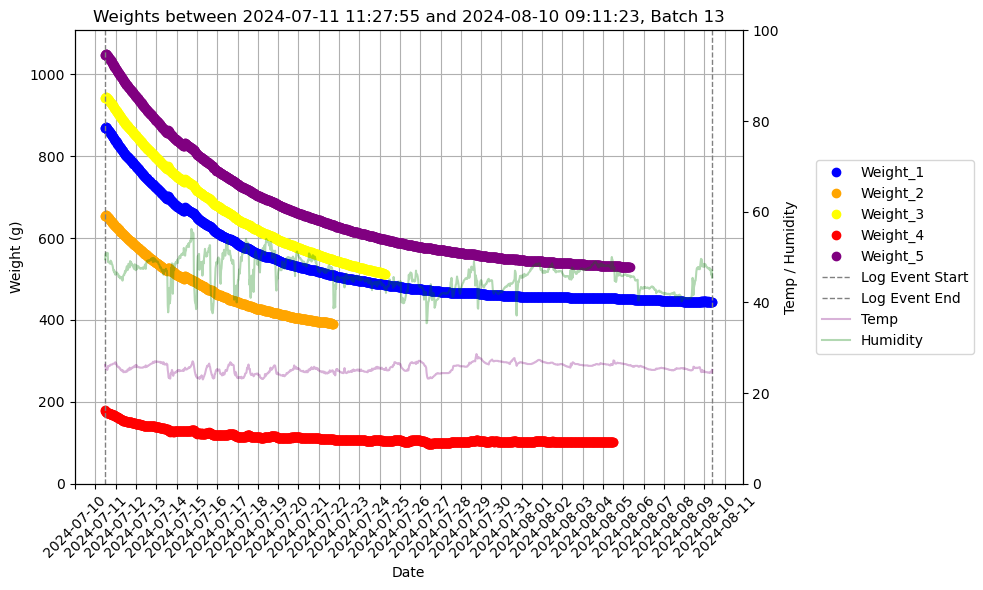

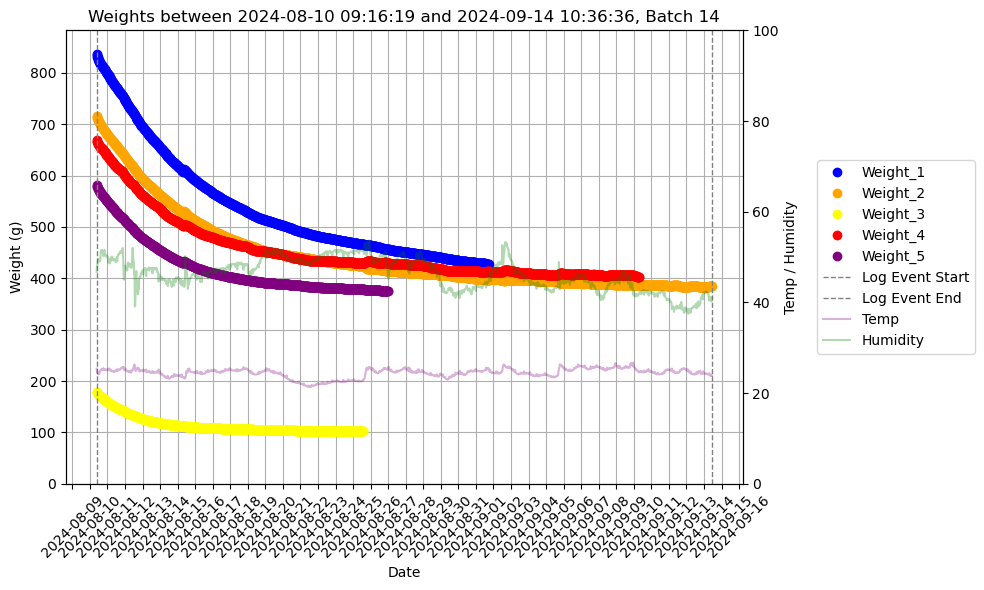

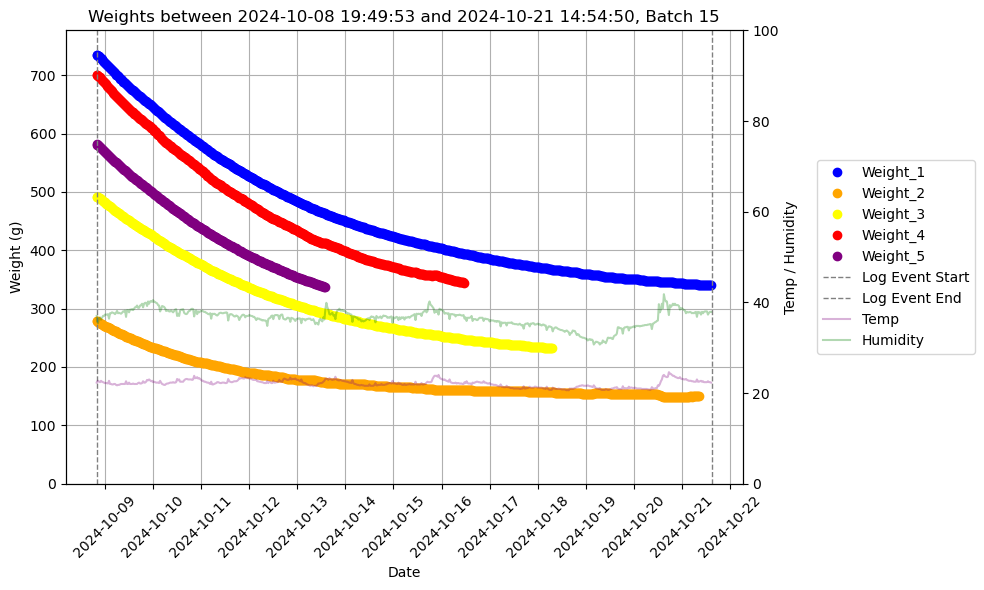

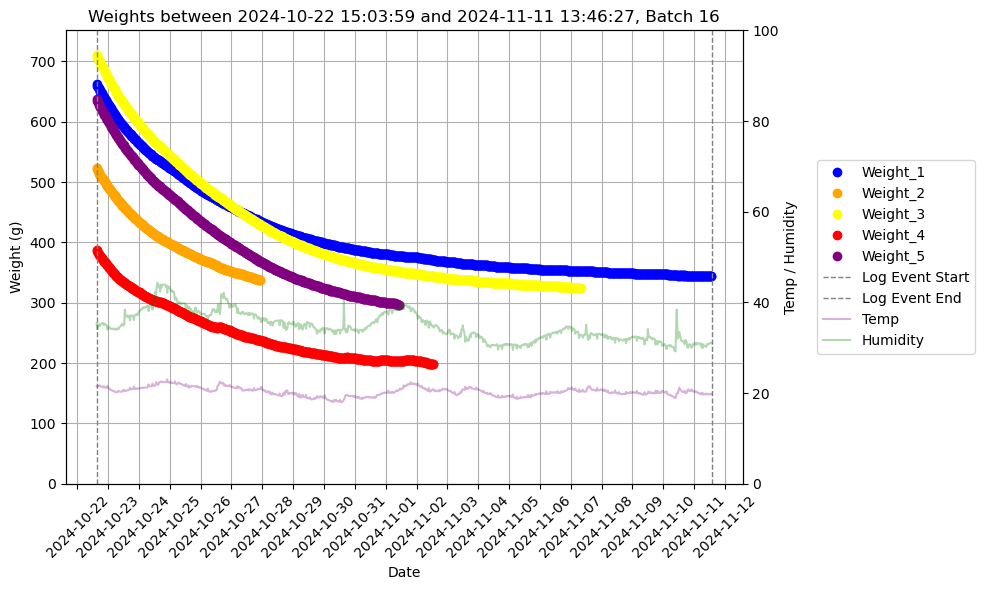

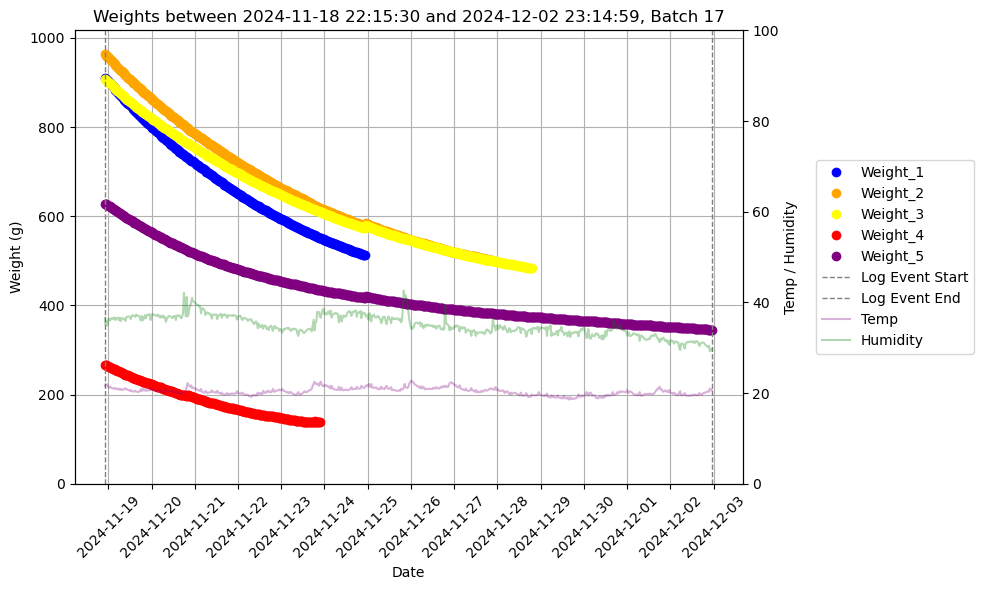

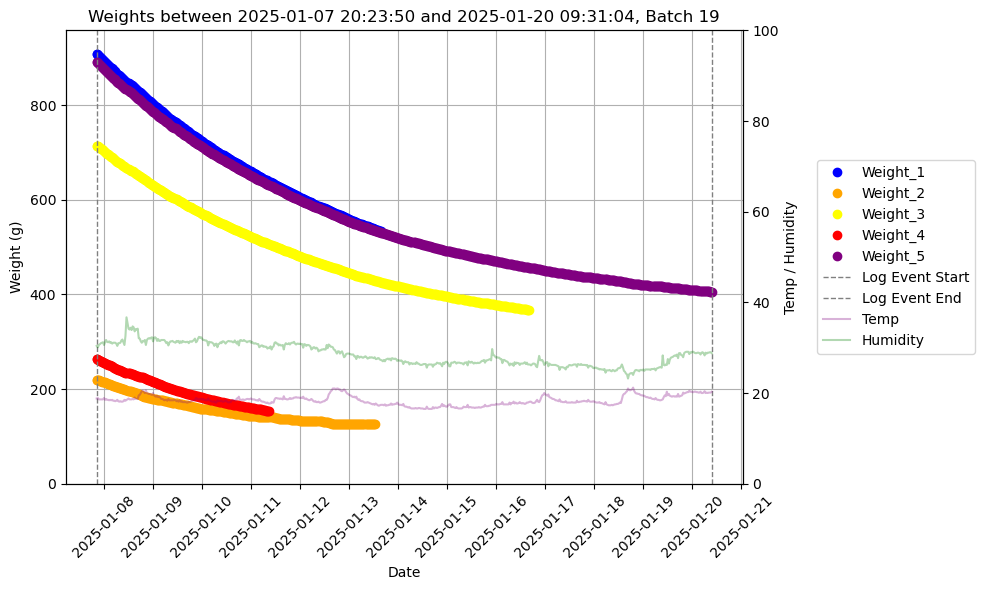

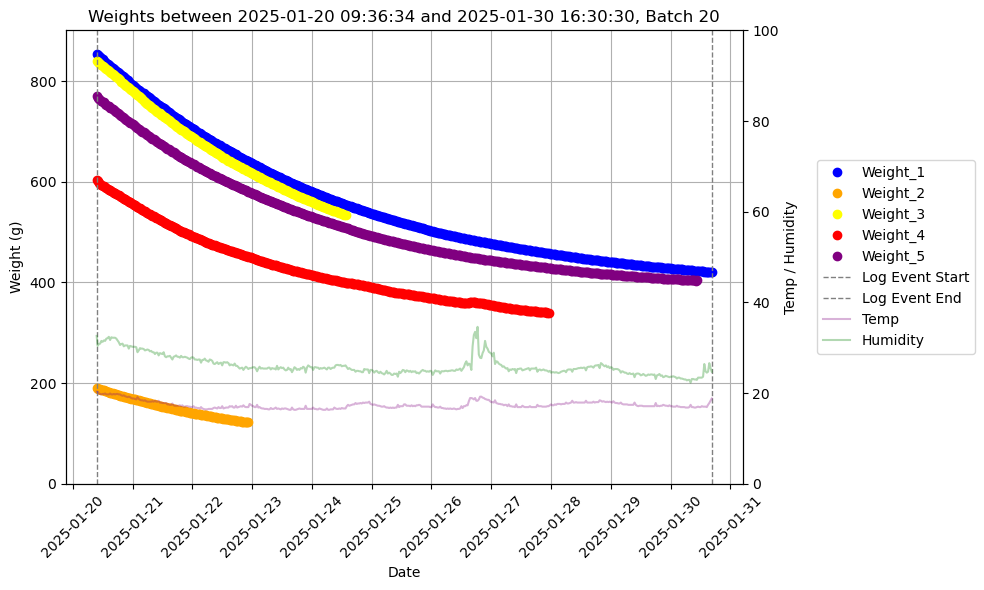

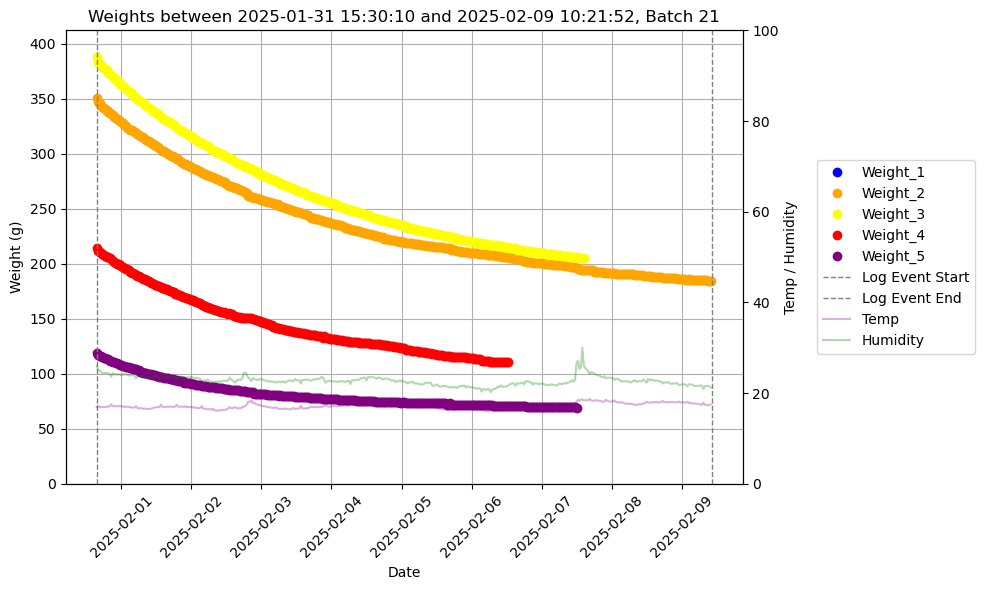

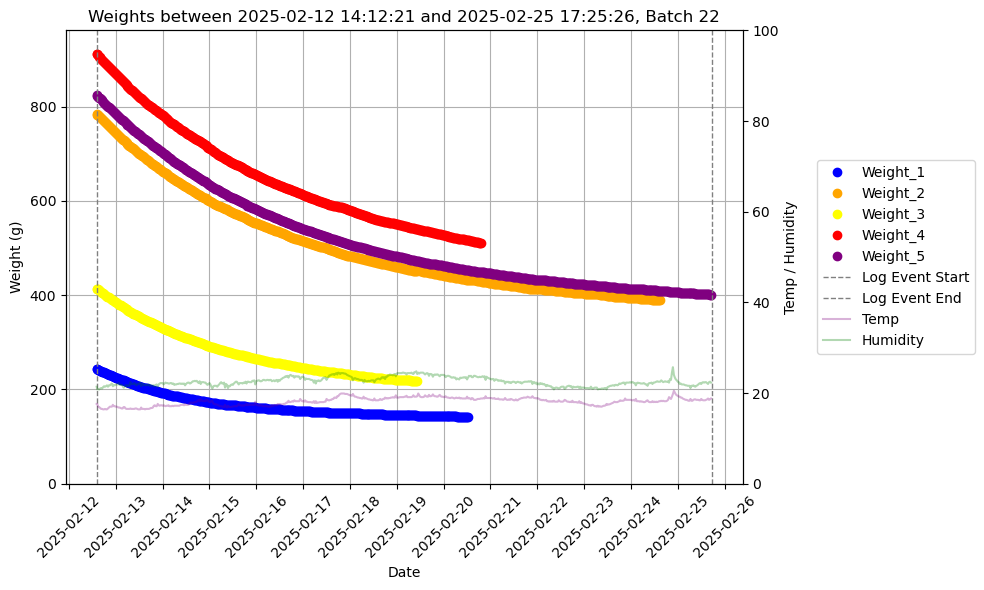

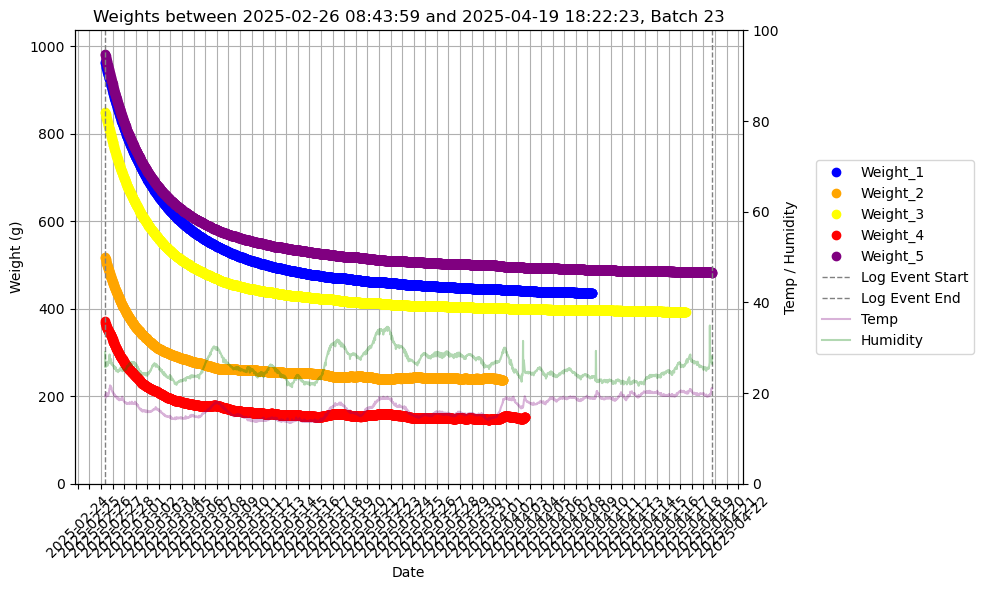

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width of the display
pd.set_option('display.max_colwidth', None)  # Show the full content of each cell

# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)

log_event_start_df = log_event_start_df.copy()
log_event_stopped_df = log_event_stopped_df.copy()

log_event_start_df.loc[:, 'Date'] = pd.to_datetime(log_event_start_df['Date']).dt.tz_localize(None)
log_event_stopped_df.loc[:, 'Date'] = pd.to_datetime(log_event_stopped_df['Date']).dt.tz_localize(None)

# Filter the combined_df to include only rows where weights are greater than 50
filtered_df = combined_df[
    (combined_df['Weight_1'] > 50) | 
    (combined_df['Weight_2'] > 50) | 
    (combined_df['Weight_3'] > 50) | 
    (combined_df['Weight_4'] > 50) | 
    (combined_df['Weight_5'] > 50)
].copy()  # Create a copy of the filtered DataFrame

# Replace weights below 50 with -100 for visualization purposes
weights = ['Weight_1', 'Weight_2', 'Weight_3', 'Weight_4', 'Weight_5']
for weight in weights:
    filtered_df.loc[filtered_df[weight] <= 50, weight] = -100

# Sort log_event_start_df by 'Date'

log_event_start_df = log_event_start_df.sort_values(by='Date')
log_event_stopped_df = log_event_stopped_df.sort_values(by='Date')

#------------Filter date ranges
# Define the date range
start_date = pd.Timestamp('2021-04-20')
end_date = pd.Timestamp('2025-05-14')

# Filter log_event_start_df
log_event_start_fil_df = log_event_start_df[(log_event_start_df['Date'] >= start_date) & (log_event_start_df['Date'] <= end_date)]

# Filter log_event_stopped_df
log_event_stopped_fil_df = log_event_stopped_df[(log_event_stopped_df['Date'] >= start_date) & (log_event_stopped_df['Date'] <= end_date)]
#------------Filter date ranges

# Plot data between each pair of log events
for i in range(len(log_event_start_fil_df)):
    start_date = log_event_start_fil_df.iloc[i]['Date']
    end_date = log_event_stopped_fil_df.iloc[i]['Date']

    # Filter data between the current and next log event
    plot_df = filtered_df[(filtered_df['Date'] >= start_date) & (filtered_df['Date'] <= end_date)]

    #----------------------------Works for first set
    if (i==0):
        #display(plot_df)
        data = plot_df.copy()
        # Convert 'Date' column to datetime
        data['Date'] = pd.to_datetime(data['Date'])

        # Set 'Date' column as index
        data.set_index('Date', inplace=True)

        #display(data.head())
        data = data.iloc[1:]
        #display(data.head())

        # Generate a complete range of timestamps
        full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='30min')
        print("Start:",data.index.min())
        print("End:",data.index.max())

        # Reindex DataFrame to include all timestamps
        
        data = data.reindex(full_range)
        #display(data.head(10))
        # Ensure all columns are numeric for interpolation
        data = data.apply(pd.to_numeric, errors='coerce')

        # Interpolate missing values
        data.interpolate(method='linear', inplace=True)

        # Reset index to make 'Date' a column again if needed
        data.reset_index(inplace=True)
        data.rename(columns={'index': 'Date'}, inplace=True)

        plot_df=data.copy()
    #----------------------------Works for first set

    #-----------------To identify sudden jumps
    # Calculate the difference in Weight

    # for Weight in weights:
    if (i==3):
        plot_df.loc[:, 'Weight_1'] = np.nan
    if (i==4):
        plot_df = plot_df.reset_index(drop=True)

        # Find the index of the specific row
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2023-05-04 22:00:00')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 47

    if (i==7):
        plot_df = plot_df.reset_index(drop=True)
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-16 21:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 155

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 100

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_1'] += 200
        

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-18 22:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 180
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 60
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-02-01 00:00:02')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 205

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_5'] += 205

        #------Specific data range to modify
        start_date_1 = '2024-01-15 23:00:01'
        end_date_1 = '2024-01-16 21:30:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_1'] = np.nan
        plot_df['Weight_1'] = plot_df['Weight_1'].interpolate()

        #------Specific data range to modify
        start_date_1 = '2024-01-16 21:30:01'
        end_date_1 = '2024-01-18 22:00:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_5'] = np.nan
        # df['Weight_1'] = df['Weight_1'].replace(-100, pd.NA)  # Replace -100 with NaN for interpolation
        plot_df['Weight_5'] = plot_df['Weight_5'].interpolate()

    #-----------------To identify sudden jumps
    if (i!=17):

        # Define a function to export weights
        def export_weights(df):
            for j in range(1, 6):  # Loop for weights from 1 to 5
                weight_col = f'Weight_{j}'
                filtered_df = df[df[weight_col] > 50].copy()  # Filter for weights greater than 50
                
                if not filtered_df.empty:  # Proceed only if there are values greater than 50
                    filtered_df['Jerky_ID'] = f"{i},{j}"  # Set the Jerky_ID column with a constant value for all rows
                    export_columns = ['Jerky_ID', 'Unix_time_Stamp', 'Date', 'Temp', 'Humidity', weight_col]
                    filtered_df = filtered_df[export_columns]  # Select required columns
                    
                    # Use raw string or double backslashes for file path
                    directory = r'pdata'  # Or use 'pdata\\'
                    filename = f'{directory}\\Jerky_{i}_{weight_col}.csv'
                    filtered_df.to_csv(filename, index=False)  # Export to CSV

        # Call the function to export weights
        export_weights(plot_df)

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot the weight data
        ax1.plot(plot_df['Date'], plot_df['Weight_1'], marker='o', linestyle='', color='b', label='Weight_1')
        ax1.plot(plot_df['Date'], plot_df['Weight_2'], marker='o', linestyle='', color='orange', label='Weight_2')
        ax1.plot(plot_df['Date'], plot_df['Weight_3'], marker='o', linestyle='', color='yellow', label='Weight_3')
        ax1.plot(plot_df['Date'], plot_df['Weight_4'], marker='o', linestyle='', color='red', label='Weight_4')
        ax1.plot(plot_df['Date'], plot_df['Weight_5'], marker='o', linestyle='', color='purple', label='Weight_5')

        # Add vertical lines for log event start and end
        ax1.axvline(x=start_date, color='gray', linestyle='--', linewidth=1, label='Log Event Start')
        ax1.axvline(x=end_date, color='gray', linestyle='--', linewidth=1, label='Log Event End')

        # Formatting the x-axis to show 1-day intervals
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        ax1.set_xlabel('Date')
        ax1.set_ylabel('Weight (g)')
        ax1.set_title(f'Weights between {start_date} and {end_date}, Batch {i+1}')
        ax1.grid(True)
        ax1.set_ylim(bottom=0)  # Ensure y-axis starts at 0
        ax1.tick_params(axis='x', rotation=45)

        # Secondary y-axis for temperature and humidity
        ax2 = ax1.twinx()
        ax2.plot(plot_df['Date'], plot_df['Temp'], '-', color='purple', label='Temp', alpha=0.3)
        ax2.plot(plot_df['Date'], plot_df['Humidity'], '-', color='green', label='Humidity', alpha=0.3)
        ax2.set_ylabel('Temp / Humidity')
        ax2.set_ylim(0, 100)  # Set explicit range for secondary axis

        # Combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        by_label = dict(zip(labels_1 + labels_2, lines_1 + lines_2))
        ax1.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.1, 0.5))

        fig.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend on the right
        plt.show()


### Description

This code performs data loading, preprocessing, and statistical analysis from multiple CSV files in a directory named `pdata`.

### Key Operations

1. **Data Loading and Preprocessing**
   - Iterates through all CSV files in `pdata`.
   - Reads each file into a DataFrame.
   - Computes a `Temp_Humidity_Ratio` as `Humidity / Temp`.
   - Detects weight column (starting with `Weight_`) and calculates its difference (`Weight_Difference`).
   - Stores processed DataFrames in a list `dfs`.

2. **Global Aggregation**
   - Aggregates temperature, humidity, temp/humidity ratio, and weight values from all DataFrames.
   - Calculates global minimum and maximum values for each parameter.

3. **Contextual Statistics**
   - Prints the corresponding temperature at minimum/maximum humidity.
   - Prints the corresponding humidity at minimum/maximum temperature.
   - Prints the temp/humidity pairs at minimum/maximum temp/humidity ratio.
   - Prints the global min and max weights.

4. **Dataset Summary**
   - Determines the longest and shortest lengths of DataFrames (in 30-minute intervals and days).

### Output

The code prints:
- Contextual temperature/humidity values associated with extreme readings.
- Global min/max values for weight.
- Range of dataset lengths in both data points and days.


In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches  # Import patches module

# Path to the directory containing CSV files
data_directory = 'pdata'

# List to hold DataFrames
dfs = []

# Iterate over all CSV files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_directory, filename)
        df = pd.read_csv(filepath)
        # Calculate the new column
        df['Temp_Humidity_Ratio'] =  df['Humidity']/df['Temp'] 
        # Identify the Weight column
        weight_cols = [col for col in df.columns if col.startswith('Weight_')]
        if weight_cols:
            weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
            
            # Calculate the difference in weight
            df['Weight_Difference'] = df[weight_col].diff()
        dfs.append(df)

# Collect all humidity values from each DataFrame
all_humidity = []
all_temp = []
all_temp_humid_ratio = []
all_weight = []

for df in dfs:
    if 'Humidity' in df.columns:
        all_humidity.extend(df['Humidity'])
    if 'Temp' in df.columns:
        all_temp.extend(df['Temp'])    
    if 'Temp_Humidity_Ratio' in df.columns:
        all_temp_humid_ratio.extend(df['Temp_Humidity_Ratio'])
        # Identify the Weight column
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    if weight_cols:
            weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
            all_weight.extend(df[weight_col])  

# Convert to a numpy array or pandas Series for easier min/max computation
all_humidity = np.array(all_humidity)
all_temp = np.array(all_temp)
all_temp_humid_ratio = np.array(all_temp_humid_ratio)
all_weight = np.array(all_weight)

# Compute min and max
min_humidity = np.min(all_humidity)
max_humidity = np.max(all_humidity)
min_temp = np.min(all_temp)
max_temp = np.max(all_temp)
min_temp_humid_ratio = np.min(all_temp_humid_ratio)
max_temp_humid_ratio = np.max(all_temp_humid_ratio)
min_weight = np.min(all_weight)
max_weight = np.max(all_weight)

# print(f"Minimum Humidity: {min_humidity}")
# Find the temperature where the minimum humidity was recorded
for df in dfs:
    if 'Humidity' in df.columns and 'Temp' in df.columns:
        min_humidity_idx = df['Humidity'].idxmin()
        if df.loc[min_humidity_idx, 'Humidity'] == min_humidity:
            corresponding_temp = df.loc[min_humidity_idx, 'Temp']
            print(f"Temperature at minimum humidity ({min_humidity}%): Temperature  {corresponding_temp}C")
            break  # Stop after finding the first match

# print(f"Maximum Humidity: {max_humidity}")
# Find the temperature where the minimum humidity was recorded
for df in dfs:
    if 'Humidity' in df.columns and 'Temp' in df.columns:
        max_humidity_idx = df['Humidity'].idxmax()
        if df.loc[max_humidity_idx, 'Humidity'] == max_humidity:
            corresponding_temp = df.loc[max_humidity_idx, 'Temp']
            print(f"Temperature at maximum humidity ({max_humidity}%): Temperature {corresponding_temp}C")
            break  # Stop after finding the first match

# print(f"Minimum Temperature: {min_temp}")
# Find the temperature where the minimum humidity was recorded
for df in dfs:
    if 'Temp' in df.columns and 'Humidity' in df.columns:
        min_temp_idx = df['Temp'].idxmin()
        if df.loc[min_temp_idx, 'Temp'] == min_temp:
            corresponding_humidity = df.loc[min_temp_idx, 'Humidity']
            print(f"Humidity at minimum temperature ({min_temp}C): Humidity  {corresponding_humidity}%")
            break  # Stop after finding the first match

# print(f"Maximum Temperature: {max_temp}")
# Find the temperature where the minimum humidity was recorded
for df in dfs:
    if 'Temp' in df.columns and 'Humidity' in df.columns:
        max_temp_idx = df['Temp'].idxmax()
        if df.loc[max_temp_idx, 'Temp'] == max_temp:
            corresponding_humidity = df.loc[max_temp_idx, 'Humidity']
            print(f"Humidity at maximum temperature ({max_temp}C): Humidity {corresponding_humidity}%")
            break  # Stop after finding the first match

# print(f"Minimum Temperature/Humidity Ratio: {min_temp_humid_ratio:.3f}")
# Find temperature and humidity where min Temp/Humidity ratio occurs
for df in dfs:
    if 'Temp_Humidity_Ratio' in df.columns and 'Temp' in df.columns and 'Humidity' in df.columns:
        min_ratio_idx = df['Temp_Humidity_Ratio'].idxmin()
        if df.loc[min_ratio_idx, 'Temp_Humidity_Ratio'] == min_temp_humid_ratio:
            min_ratio_temp = df.loc[min_ratio_idx, 'Temp']
            min_ratio_humidity = df.loc[min_ratio_idx, 'Humidity']
            print(f"At min Temp/Humidity ratio ({min_temp_humid_ratio:.3f}): Temp={min_ratio_temp}C, Humidity={min_ratio_humidity}%")
            break

# print(f"Maximum Temperature/Humidity Ratio: {max_temp_humid_ratio:.3f}")
# Find temperature and humidity where max Temp/Humidity ratio occurs
for df in dfs:
    if 'Temp_Humidity_Ratio' in df.columns and 'Temp' in df.columns and 'Humidity' in df.columns:
        max_ratio_idx = df['Temp_Humidity_Ratio'].idxmax()
        if df.loc[max_ratio_idx, 'Temp_Humidity_Ratio'] == max_temp_humid_ratio:
            max_ratio_temp = df.loc[max_ratio_idx, 'Temp']
            max_ratio_humidity = df.loc[max_ratio_idx, 'Humidity']
            print(f"At max Temp/Humidity ratio ({max_temp_humid_ratio:.3f}): Temp={max_ratio_temp}C, Humidity={max_ratio_humidity}%")
            break

print(f"Minimum Weight: {min_weight}g")
print(f"Maximum Weight: {max_weight}g")

# Initialize variable to store the maximum length
max_length = 0
min_length = float('inf')

# Iterate over each DataFrame to find the maximum index length
for df in dfs:
    index_length = len(df.index)
    if index_length > max_length:
        max_length = index_length
    if index_length < min_length:
        min_length = index_length

print(f"Longest index length: {max_length} (points @ 30 min interval) or {max_length/48:.1f} days")
print(f"Shortest index length: {min_length} (points @ 30 min interval) or {min_length/48:.1f} days")

Temperature at minimum humidity (17.9%): Temperature  16.7C
Temperature at maximum humidity (56.2%): Temperature 26.2C
Humidity at minimum temperature (13.4C): Humidity  21.9%
Humidity at maximum temperature (28.6C): Humidity 45.1%
At min Temp/Humidity ratio (1.072): Temp=16.7C, Humidity=17.9%
At max Temp/Humidity ratio (2.559): Temp=21.1C, Humidity=54.0%
Minimum Weight: 51.0g
Maximum Weight: 1162.0g
Longest index length: 2516 (points @ 30 min interval) or 52.4 days
Shortest index length: 123 (points @ 30 min interval) or 2.6 days


### Description

This code analyzes and visualizes the drying trends of biltong (jerky) by calculating normalized weight loss across multiple datasets. It identifies a "golden biltong line," defined as ±1 standard deviation around the mean normalized weight loss curve, to characterize optimal drying behavior.

### Key Operations

1. **Normalization & Preprocessing**
   - Weights are normalized to their initial value per dataset.
   - Humidity values are clipped to global min/max range.
   - Only the first 4 days of data (based on 30-min intervals) are used.

2. **Data Aggregation**
   - Normalized weight data from all CSV files is aggregated into a new DataFrame for statistical analysis.

3. **Visualization**
   - All individual normalized drying curves are plotted using a humidity-based color gradient.
   - Dot size reflects the relative weight of the meat sample.
   - A colorbar indicates the corresponding humidity.

4. **Statistical Curves**
   - **Mean** and **median** normalized weight curves are plotted.
   - **"Golden Biltong Line"**: ±1 standard deviation around the mean, plotted in green with a yellow dash gap.
   - **Shaded Zones**:
     - *Ideal biltong zone*: Between 0.4 (can be 0) and upper std bound.
     - *Hazard biltong zone*: Above upper std bound.

5. **Legend and Display**
   - Legend is filtered to include only meaningful elements (mean, median, ideal/hazard zones, and threshold).
   - The largest DataFrame is used for aligning the index for consistent plotting.

### Output

A comprehensive scatter and line plot showing:
- All historical normalized drying curves.
- The average drying trend (mean and median).
- The one-standard-deviation envelope (golden line).
- Visual zones representing optimal and risky drying behaviors.


Shape of the largest DataFrame: (2516, 9)


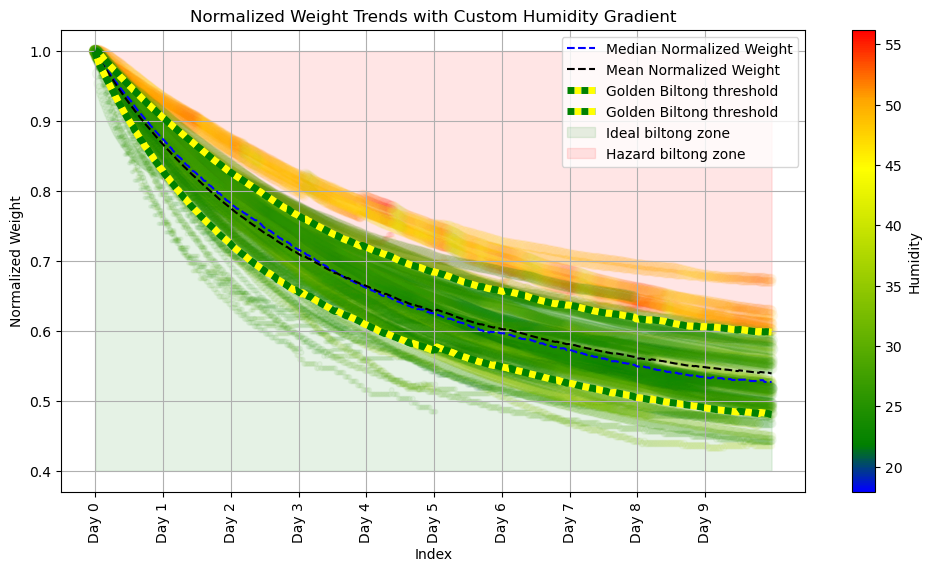

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import numpy as np
from matplotlib.lines import Line2D

# Define normalization for colormap
norm = Normalize(vmin=min_humidity, vmax=max_humidity)

colors = [(0, 'blue'), (0.1, 'green'),(0.7, 'yellow'),(0.85, 'orange'), (1, 'red')]  # Blue at 20, Green at 40, Red at 60
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Only needed for ScalarMappable to work with colorbar

# Create a new DataFrame to store normalized weights
all_normalized_weights = pd.DataFrame()

# Create the main plot
fig, ax = plt.subplots(figsize=(12, 6))  

# Define the range to plot (first 4 days)
start_index = 0
end_index = 10 * 48  # 4 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Add normalized weight to the new DataFrame
        all_normalized_weights = pd.concat([all_normalized_weights, df[['Normalized_Weight']]], axis=1)

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        # Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) * 80
        
        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.05, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Find the DataFrame with the most rows
df_filtered = max(dfs, key=lambda df: df.shape[0])

# Print the shape of the largest DataFrame to confirm
print("Shape of the largest DataFrame:", df_filtered.shape)
df_filtered = df_filtered.iloc[start_index:end_index]

# Calculate and plot statistics
if not all_normalized_weights.empty:
    # Ensure the index is aligned for statistics calculation
    aligned_weights = all_normalized_weights.reindex(df_filtered.index)
    
    mean_weights = aligned_weights.mean(axis=1)
    std_weights = aligned_weights.std(axis=1)
    median_weights = aligned_weights.median(axis=1)
    
    # Plot median and std deviation
    ax.plot(df_filtered.index, median_weights, color='blue', linestyle='--', label='Median Normalized Weight')

    # Plot mean and std deviation
    ax.plot(df_filtered.index, mean_weights, color='black', linestyle='--', label='Mean Normalized Weight')
    
    ax.plot(df_filtered.index, mean_weights + std_weights, color='green', linestyle='-', linewidth=5,dashes=[1, 1], gapcolor='yellow', label ='Golden Biltong threshold')
    ax.plot(df_filtered.index, mean_weights - std_weights, color='green', linestyle='-', linewidth=5,dashes=[1, 1], gapcolor='yellow', label ='Golden Biltong threshold')
 
    ax.fill_between(df_filtered.index, 0.4, mean_weights + std_weights, color='green', alpha=0.1, label='Ideal biltong zone')
    ax.fill_between(df_filtered.index, mean_weights + std_weights, 1, color='red', alpha=0.1, label='Hazard biltong zone')

# # Add custom legend entries
handles, labels = ax.get_legend_handles_labels()

# Only show legend for Mean, Median, and Std Dev, plus the custom handle
filtered_handles = [handle for handle, label in zip(handles, labels) if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Hazard biltong zone', 'Golden Biltong threshold']]
filtered_labels = [label for label in labels if label in ['Mean Normalized Weight', 'Median Normalized Weight', 'Ideal biltong zone', 'Hazard biltong zone', 'Golden Biltong threshold']]

ax.legend(filtered_handles, filtered_labels)
plt.show()

### Description

In this cell, we fit exponential decay models to the drying curves of biltong using `scipy.optimize.curve_fit`. This helps to approximate the drying behavior using smooth analytical functions for further analysis or prediction.

### Key Operations

1. **Model Definition**
   - A standard exponential decay function is defined:
    $y(t) = a \cdot e^{-b \cdot t} + c$
    
        Where:
        - \( y(t) \) is the normalized weight at time \( t \),
        - \( a \), \( b \), and \( c \) are fitted parameters,
        - \( t \) is time (in days).

   - This models how the normalized weight decreases over time during drying.

2. **Data Preparation**
   - Three datasets are prepared:
     - `mean_weights + std_weights`: Upper golden threshold
     - `mean_weights`: Central tendency
     - `mean_weights - std_weights`: Lower golden threshold
   - These are fitted over a time range up to `trim_value = 800`.

3. **Curve Fitting**
   - The `curve_fit` function finds optimal parameters for the model.
   - Separate fits are performed for the mean, upper, and lower bounds.

4. **Plotting**
   - Original observed values for `mean + std`, `mean` and `mean - std` are shown as blue dots.
   - Fitted exponential curves are plotted for:
     - Upper threshold (red)
     - Mean (blue)
     - Lower threshold (red, reused)
   - Equations for each fit are included in the legend.

5. **Secondary Axis**
   - A top x-axis is added to convert 30-minute intervals to days for easier interpretation.

6. **Gridlines**
   - Major and minor gridlines improve readability.

### Output

A detailed plot showing:
- Observed and fitted curves for biltong drying behavior.
- Clear exponential models with labeled equations.
- A secondary axis converting time intervals to days.


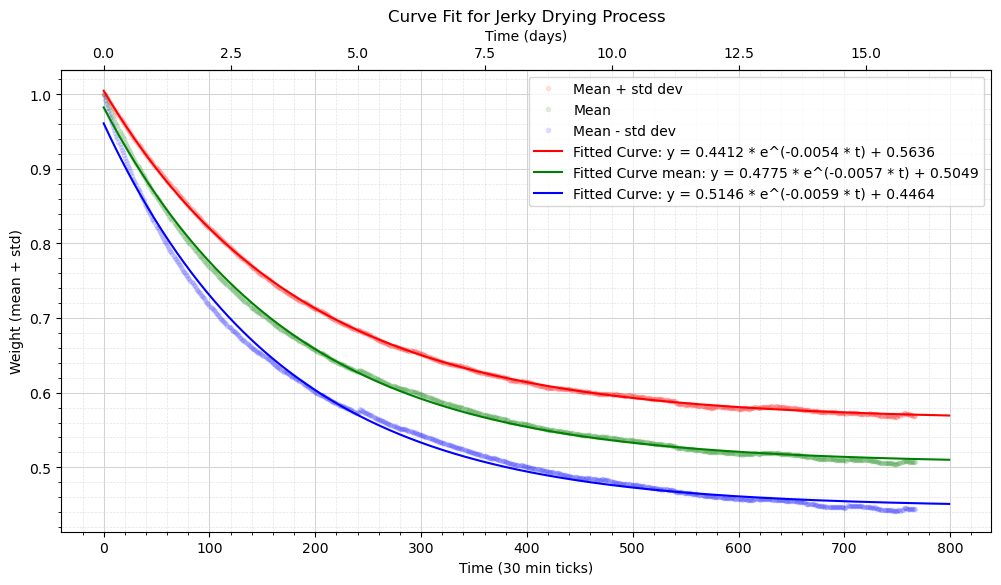

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example drying function (exponential decay model)
def drying_curve(time, a, b, c):
    return a * np.exp(-b * time) + c

# Your weights: Replace with your actual values for mean_weights + std_weights
mean_p_std_weights = np.array(mean_weights + std_weights)
mean_weights = np.array(mean_weights)
mean_n_std_weights = np.array(mean_weights - std_weights)

trim_value = 800
# Time array (assuming data was recorded at regular intervals)
time = np.arange(len(mean_p_std_weights))  # Create a time array of the same length
time_ext = np.arange(trim_value)
trimmed_time = time[time < trim_value]
trimmed_mean_p_std_weights = mean_p_std_weights[time < trim_value]
trimmed_mean_weights = mean_weights[time < trim_value]
trimmed_mean_n_std_weights = mean_n_std_weights[time < trim_value]

# Fit the curve to the data
popt1, pcov = curve_fit(drying_curve, time, mean_p_std_weights, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
popt2, pcov = curve_fit(drying_curve, time, mean_weights, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
popt3, pcov = curve_fit(drying_curve, time, mean_n_std_weights, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# popt contains the optimized values of a, b, c
a, b, c = popt1
d, e, f = popt2
g, h, i = popt3

# Generate fitted values using the model
fitted_weights_dev1 = drying_curve(time, a, b, c)
fitted_weights_mean = drying_curve(time, d, e, f)
fitted_weights_n_dev1= drying_curve(time, g, h, i)

# Generate fitted values using the model
fitted_weights_dev1_ext = drying_curve(time_ext, a, b, c)
fitted_weights_mean_ext = drying_curve(time_ext, d, e, f)
fitted_weights_n_dev1_ext = drying_curve(time_ext, g, h, i)

fig, ax = plt.subplots(figsize=(12, 6))  # Create the main plot
# Plot the original data and the fitted curve
ax.plot(trimmed_time, trimmed_mean_p_std_weights, 'r.', label='Mean + std dev', alpha=0.1) 
ax.plot(trimmed_time, trimmed_mean_weights, 'g.', label='Mean', alpha=0.1) 
ax.plot(trimmed_time, trimmed_mean_n_std_weights, 'b.', label='Mean - std dev', alpha=0.1) 
ax.plot(time_ext, fitted_weights_dev1_ext, 'r-', label=f'Fitted Curve: y = {a:.4f} * e^(-{b:.4f} * t) + {c:.4f}')
ax.plot(time_ext, fitted_weights_mean_ext, 'g-', label=f'Fitted Curve mean: y = {d:.4f} * e^(-{e:.4f} * t) + {f:.4f}')
ax.plot(time_ext, fitted_weights_n_dev1_ext, 'b-', label=f'Fitted Curve: y = {g:.4f} * e^(-{h:.4f} * t) + {i:.4f}')
ax.set_xlabel('Time (30 min ticks)')
ax.set_ylabel('Weight (mean + std)')
ax.legend()
ax.set_title('Curve Fit for Jerky Drying Process')

# Secondary x-axis (time in days)
def intervals_to_days(x):
    return x * 0.5 / 24  # each tick = 30 min, so 0.5 hours

def days_to_intervals(x):
    return x * 24 / 0.5

secax = ax.secondary_xaxis('top', functions=(intervals_to_days, days_to_intervals))
secax.set_xlabel('Time (days)')

# Add major gridlines
ax.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.75)

# Add minor ticks and gridlines
ax.minorticks_on()
ax.grid(which='minor', color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.6)

plt.show()

### Curve Fitting with the Golden Biltong Threshold

Now we combine the **golden biltong ratio** with our **fitted curve**.  
The fitted curve aligns closely with the actual data during the initial drying period, indicating a good fit.  
However, after **day 9**, a noticeable **deviation** appears between the actual and the fitted data, likely due to changing drying dynamics or external conditions.

The model used for curve fitting is based on an exponential decay function as used earlier:

$y(t) = a \cdot e^{-b \cdot t} + c$

The shaded bands (±1 standard deviation) around the mean represent the **Golden Biltong Threshold**, offering a visual cue for the acceptable drying range based on historical data.


Shape of the largest DataFrame: (2516, 9)


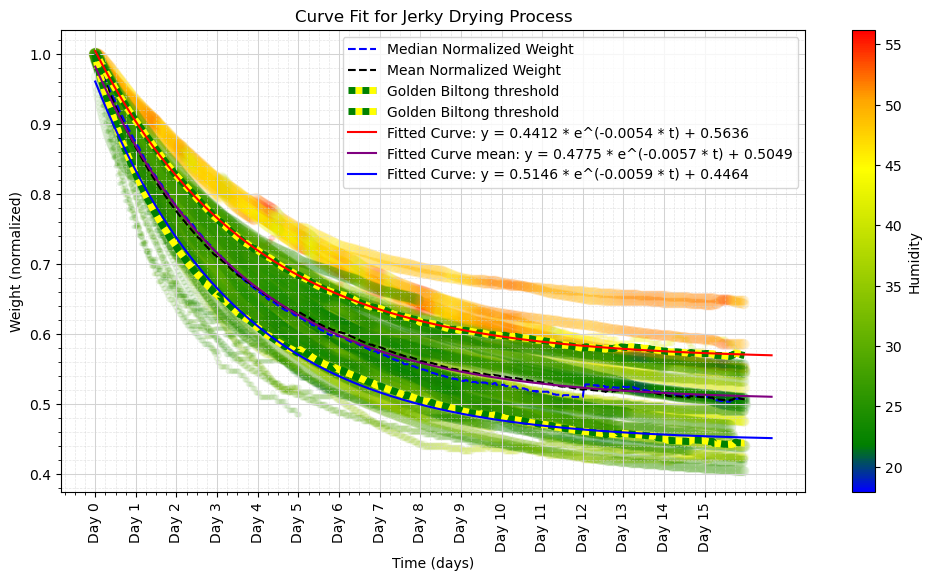

In [71]:
# Create the main plot
fig, ax = plt.subplots(figsize=(12, 6))  

# Define the range to plot (first 4 days)
start_index = 0
end_index = 16 * 48  # 15 days worth of data

# Iterate through each DataFrame and plot
for df in dfs:
    # Identify the Weight column (find column that starts with 'Weight_')
    weight_cols = [col for col in df.columns if col.startswith('Weight_')]
    
    if weight_cols:
        weight_col = weight_cols[0]  # Assuming only one Weight column per DataFrame
        
        # Normalize the Weight column
        df['Normalized_Weight'] = (df[weight_col] / df[weight_col].max())
        
        # Normalize Humidity
        df['Humidity'] = df['Humidity'].clip(lower=min_humidity, upper=max_humidity)  # Clip values to the range min-max

        # Filter the DataFrame to include only the first 4 days
        df_filtered = df.iloc[start_index:end_index]

        # Add normalized weight to the new DataFrame
        all_normalized_weights = pd.concat([all_normalized_weights, df[['Normalized_Weight']]], axis=1)

        # Map humidity to color
        colors = custom_cmap(norm(df_filtered['Humidity']))

        # Dot size, depends on how large the piece is
        dot_size = (df[weight_col].max()/max_weight) * 80
        
        # Scatter plot with gradient colors
        plt.scatter(df_filtered.index, df_filtered['Normalized_Weight'], c=colors, s=dot_size, alpha=0.05, label=weight_col)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Humidity')

# Set x-ticks at intervals of 48
tick_positions = range(start_index, end_index, 48)
tick_labels = [f'Day {i // 48 + 0}' for i in tick_positions]

# Apply the ticks and labels to the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)  # Rotate labels if needed

# Add grid
ax.grid(True)  # Adds grid lines

plt.xlabel('Index')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weight Trends with Custom Humidity Gradient')

# Find the DataFrame with the most rows
df_filtered = max(dfs, key=lambda df: df.shape[0])

# Print the shape of the largest DataFrame to confirm
print("Shape of the largest DataFrame:", df_filtered.shape)
df_filtered = df_filtered.iloc[start_index:end_index]

# Calculate and plot statistics
if not all_normalized_weights.empty:
    # Ensure the index is aligned for statistics calculation
    aligned_weights = all_normalized_weights.reindex(df_filtered.index)
    
    mean_weights = aligned_weights.mean(axis=1)
    std_weights = aligned_weights.std(axis=1)
    median_weights = aligned_weights.median(axis=1)
    
    # Plot median and std deviation
    ax.plot(df_filtered.index, median_weights, color='blue', linestyle='--', label='Median Normalized Weight')

    # Plot mean and std deviation
    ax.plot(df_filtered.index, mean_weights, color='black', linestyle='--', label='Mean Normalized Weight')
    
    ax.plot(df_filtered.index, mean_weights + std_weights, color='green', linestyle='-', linewidth=5,dashes=[1, 1], gapcolor='yellow', label ='Golden Biltong threshold')
    ax.plot(df_filtered.index, mean_weights - std_weights, color='green', linestyle='-', linewidth=5,dashes=[1, 1], gapcolor='yellow', label ='Golden Biltong threshold')

#Plot the fitted curve
# Plot the original data and the fitted curve
label_fitted_mean_std_dev_p = f'Fitted Curve: y = {a:.4f} * e^(-{b:.4f} * t) + {c:.4f}'
label_fitted_mean = f'Fitted Curve mean: y = {d:.4f} * e^(-{e:.4f} * t) + {f:.4f}'
label_fitted_mean_std_dev_m = f'Fitted Curve: y = {g:.4f} * e^(-{h:.4f} * t) + {i:.4f}'
ax.plot(time_ext, fitted_weights_dev1_ext, color='red', label=label_fitted_mean_std_dev_p)
ax.plot(time_ext, fitted_weights_mean_ext, color='purple', label=label_fitted_mean)
ax.plot(time_ext, fitted_weights_n_dev1_ext, color='blue', label=label_fitted_mean_std_dev_m)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Weight (normalized)')

# # Add custom legend entries
handles, labels = ax.get_legend_handles_labels()

# Only show legend for Mean, Median, and Std Dev, plus the custom handle
filtered_handles = [handle for handle, label in zip(handles, labels) if label in ['Ideal biltong zone','Mean Normalized Weight', 'Median Normalized Weight',  'Hazard biltong zone', 'Golden Biltong threshold',label_fitted_mean,label_fitted_mean_std_dev_p,label_fitted_mean_std_dev_m]]
filtered_labels = [label for label in labels if label in ['Ideal biltong zone','Mean Normalized Weight', 'Median Normalized Weight',  'Hazard biltong zone', 'Golden Biltong threshold',label_fitted_mean,label_fitted_mean_std_dev_p,label_fitted_mean_std_dev_m]]
ax.legend(filtered_handles, filtered_labels)
ax.set_title('Curve Fit for Jerky Drying Process')

# Add major gridlines
ax.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.75)

# Add minor ticks and gridlines
ax.minorticks_on()
ax.grid(which='minor', color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.6)

plt.show()

In [73]:
try:
    client
except NameError:
    print("No dask client defined, nothing to shut down.")
else:
    print("Shutting down the Dask client.")
    client.close()
    del client

No dask client defined, nothing to shut down.
